# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version = '17'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="rimedsnow"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2150090)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 17:34:22 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_rimedsnow.values
    num_s  = xr.open_dataset(fname).n_rimedsnow.values
    rime_s = xr.open_dataset(fname).rime_rimedsnow.values
    rvol_s = xr.open_dataset(fname).rvol_rimedsnow.values
    liq_s  = xr.open_dataset(fname).liq_rimedsnow.values
    # process rates
    melt_c_num   = xr.open_dataset(fname).melt_rimedsnow_cloud_num.values 
    melt_c_mass  = xr.open_dataset(fname).melt_rimedsnow_cloud_mass.values   
    melt_r_num   = xr.open_dataset(fname).melt_rimedsnow_rain_num.values 
    melt_r_mass  = xr.open_dataset(fname).melt_rimedsnow_rain_mass.values   
    # rescale process rate with temperature 
    t_3 = 273.15
#    melt_c_num  = melt_c_num 
#    melt_c_mass = melt_c_mass 
#    melt_r_num  = melt_r_num 
#    melt_r_mass = melt_r_mass 
    # total and ratio
    melt_num  = melt_c_num  + melt_r_num
    melt_mass = melt_c_mass + melt_r_mass
    frac_num  = melt_r_num  / melt_num
    frac_mass = melt_r_mass / melt_mass
    # some numerical lower bounds
    q_min = 1e-15
    n_min = 1e-15
    z_min = 1e-20
    p_min = 1e-20
    # use liquid water fraction (no log transform for this)
    liq_s = np.where(q_s>q_min,liq_s/q_s,np.nan)   
    # transform everything in log space
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*q_s)
    num_s  = np.log(num_s, where=num_s>n_min, out=np.nan*num_s)
    rime_s = np.log(rime_s, where=rime_s>q_min, out=np.nan*rime_s)
    rvol_s = np.log(rvol_s, where=rvol_s>q_min, out=np.nan*rvol_s)
    melt_num   = np.log(melt_num,  where=melt_num>p_min,  out=np.nan*melt_num)
    melt_mass  = np.log(melt_mass, where=melt_mass>p_min, out=np.nan*melt_mass)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, num_s, rime_s, rvol_s, liq_s, temp, melt_mass ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'num_s', 'rime_s', 'rvol_s', 'liq_s', 'temp', 'melt_mass' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_s          num_s         rime_s         rvol_s  \
count  598030.000000  598030.000000  598030.000000  598030.000000   
mean       -5.826643       3.241717      -7.204858     -13.204268   
std         1.364075       3.196068       2.112801       2.050306   
min       -22.959127     -14.467842     -29.401039     -34.498497   
25%        -6.219018       1.985485      -7.910094     -13.840144   
50%        -5.607781       3.947487      -6.812536     -12.817161   
75%        -5.102948       5.151672      -5.897902     -12.022868   
max        -3.506558      12.781927      -3.626731      -9.055989   

               liq_s           temp      melt_mass  
count  598030.000000  598030.000000  598030.000000  
mean        0.460533     275.984253     -16.056486  
std         0.273804       1.924889       4.100480  
min         0.000167     273.109985     -36.490234  
25%         0.216832     274.510010     -18.783271  
50%         0.432557     275.589996     -15.578429  
75%         0.684501     276.959991     -12.730233  
max         1.000000     289.910004      -6.435193

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]
df2 = df[~msk]

msk = np.random.rand(len(df2)) < 0.5
dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s     num_s    rime_s     rvol_s     liq_s        temp  melt_mass
113 -6.960260  8.157972 -7.537158 -12.625627  0.144312  273.579987 -20.086361
114 -6.959196  8.156855 -7.550875 -12.639166  0.157497  273.600006 -18.135300
116 -6.957008  8.149948 -7.580472 -12.668362  0.185190  273.649994 -15.907956
117 -6.956095  8.140899 -7.596393 -12.684044  0.199515  273.670013 -15.201149
118 -6.955444  8.126607 -7.613056 -12.700467  0.213985  273.690002 -14.413616

In [11]:
dataset_train.describe()

q_s          num_s         rime_s         rvol_s  \
count  418632.000000  418632.000000  418632.000000  418632.000000   
mean       -5.824677       3.248305      -7.201196     -13.200861   
std         1.358201       3.190557       2.107750       2.044783   
min       -22.956511     -14.467842     -29.232143     -34.498497   
25%        -6.218729       1.988713      -7.908488     -13.840031   
50%        -5.607318       3.948586      -6.810493     -12.815007   
75%        -5.102570       5.156754      -5.896591     -12.020224   
max        -3.506558      12.768627      -3.627972      -9.055989   

               liq_s           temp      melt_mass  
count  418632.000000  418632.000000  418632.000000  
mean        0.460094     275.981201     -16.057196  
std         0.273657       1.924973       4.097817  
min         0.000167     273.109985     -36.490234  
25%         0.216771     274.510010     -18.773780  
50%         0.432045     275.579987     -15.578484  
75%         0.683703     276.959991     -12.737854  
max         1.000000     289.910004      -6.484372

In [12]:
dataset_test.describe()

q_s         num_s        rime_s        rvol_s         liq_s  \
count  89787.000000  89787.000000  89787.000000  89787.000000  89787.000000   
mean      -5.830774      3.230165     -7.211549    -13.210810      0.460798   
std        1.369813      3.209350      2.114418      2.053345      0.273941   
min      -22.959127    -13.774656    -29.363474    -34.418598      0.001503   
25%       -6.221406      1.969250     -7.915860    -13.842532      0.216180   
50%       -5.609555      3.950801     -6.817183    -12.823222      0.432933   
75%       -5.106384      5.151093     -5.905342    -12.031607      0.685708   
max       -3.506825     12.781927     -3.633369     -9.068147      1.000000   

               temp     melt_mass  
count  89787.000000  89787.000000  
mean     275.986053    -16.056528  
std        1.920089      4.107328  
min      273.130005    -35.604927  
25%      274.519989    -18.799150  
50%      275.589996    -15.587079  
75%      276.970001    -12.726410  
max      289.140015     -6.435193

In [13]:
dataset_val.describe()

q_s         num_s        rime_s        rvol_s         liq_s  \
count  89611.000000  89611.000000  89611.000000  89611.000000  89611.000000   
mean      -5.831690      3.222517     -7.215252    -13.213661      0.462315   
std        1.385520      3.208356      2.134609      2.072875      0.274349   
min      -22.533842    -13.774656    -29.401039    -34.449852      0.000207   
25%       -6.217763      1.988258     -7.913082    -13.838825      0.217694   
50%       -5.608354      3.940669     -6.816088    -12.821925      0.434665   
75%       -5.101896      5.131022     -5.896718    -12.026430      0.687271   
max       -3.507391     12.768599     -3.626731     -9.083619      0.999924   

               temp     melt_mass  
count  89611.000000  89611.000000  
mean     275.997131    -16.053108  
std        1.929261      4.106088  
min      273.109985    -35.145184  
25%      274.519989    -18.812691  
50%      275.600006    -15.570477  
75%      276.980011    -12.699387  
max      289.690002     -7.323563

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_s          num_s         rime_s         rvol_s  \
count  418529.000000  418529.000000  418529.000000  418529.000000   
mean       -5.820899       3.251293      -7.196856     -13.196521   
std         1.336782       3.184732       2.089433       2.025964   
min       -19.917505     -13.259214     -29.111626     -34.485615   
25%        -6.218014       1.990965      -7.907292     -13.838964   
50%        -5.607128       3.949242      -6.809994     -12.814621   
75%        -5.102422       5.157042      -5.896300     -12.020024   
max        -3.506558      12.768627      -3.627972      -9.055989   

               liq_s           temp      melt_mass  
count  418529.000000  418529.000000  418529.000000  
mean        0.460013     275.980713     -16.055246  
std         0.273612       1.923588       4.096256  
min         0.000167     273.109985     -36.490234  
25%         0.216726     274.510010     -18.771368  
50%         0.432005     275.579987     -15.577028  
75%         0.683607     276.959991     -12.737278  
max         1.000000     289.910004      -6.484372

In [17]:
dataset_test.describe()

q_s         num_s        rime_s        rvol_s         liq_s  \
count  89765.000000  89765.000000  89765.000000  89765.000000  89765.000000   
mean      -5.827023      3.233109     -7.207084    -13.206364      0.460716   
std        1.348797      3.203683      2.094882      2.033490      0.273892   
min      -19.752449    -12.542553    -27.470264    -32.993599      0.001503   
25%       -6.220878      1.971174     -7.914271    -13.841393      0.216121   
50%       -5.609364      3.951513     -6.816818    -12.822851      0.432798   
75%       -5.106260      5.151324     -5.905177    -12.031481      0.685648   
max       -3.506825     12.781927     -3.633369     -9.068147      1.000000   

               temp     melt_mass  
count  89765.000000  89765.000000  
mean     275.985687    -16.054678  
std        1.919198      4.105929  
min      273.130005    -35.604927  
25%      274.519989    -18.797035  
50%      275.589996    -15.586086  
75%      276.970001    -12.725744  
max      289.140015     -6.435193

### Pairplot

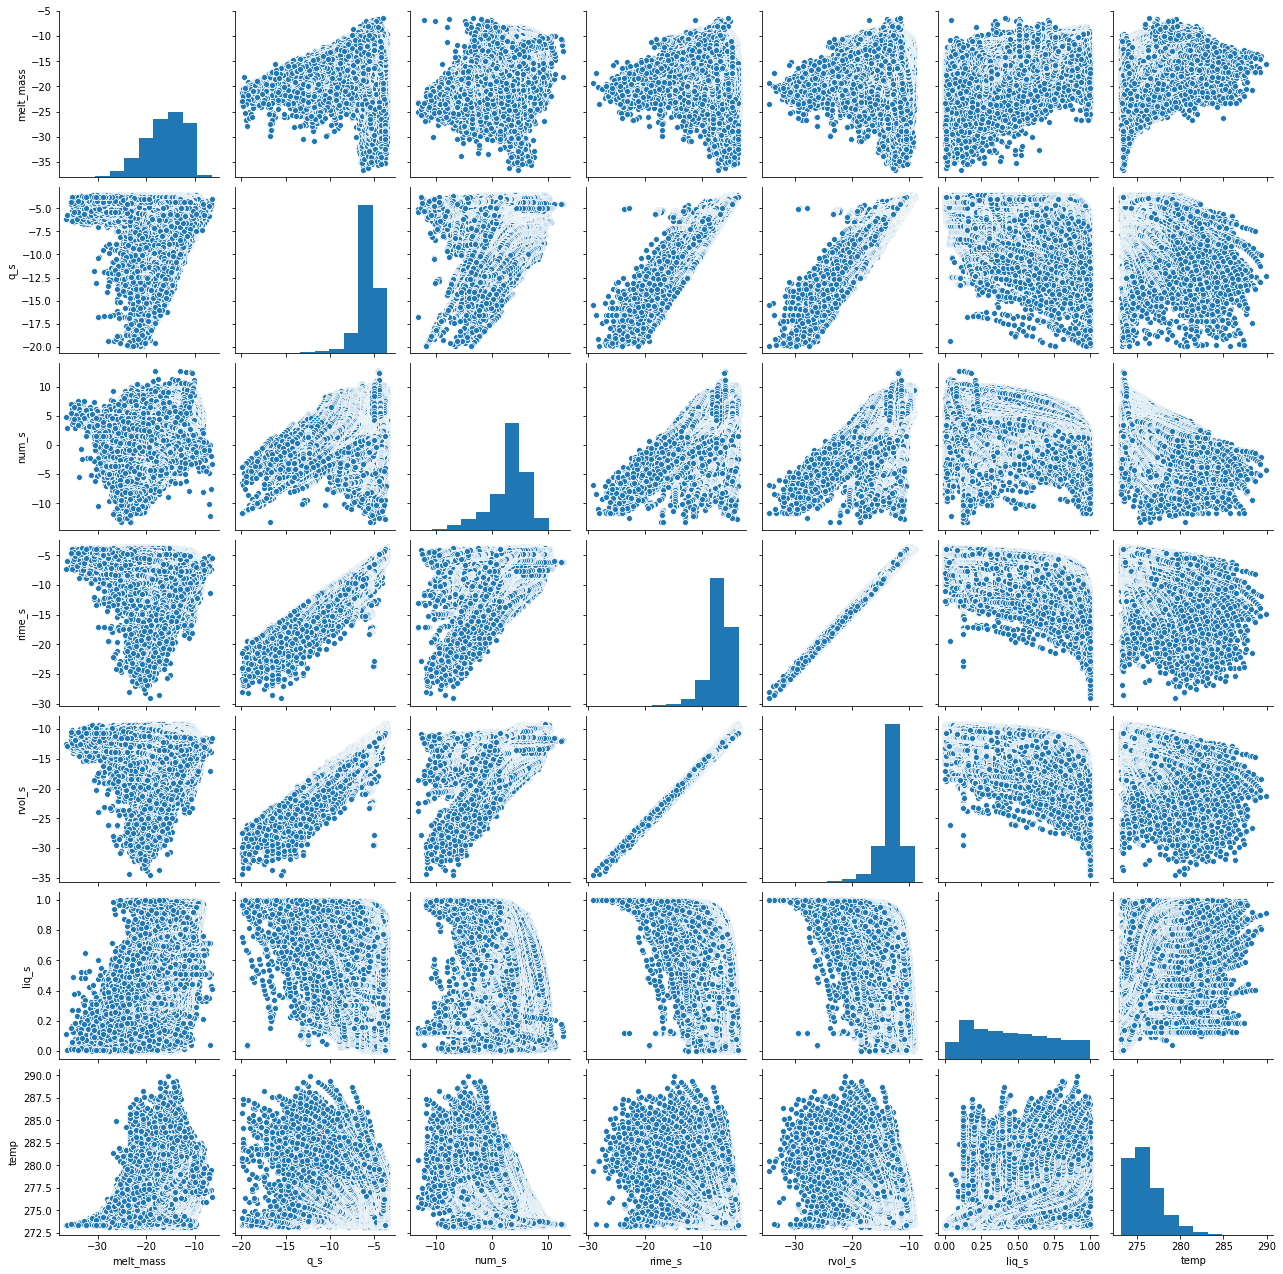

In [18]:
sns.pairplot(dataset_train[["melt_mass","q_s","num_s","rime_s","rvol_s","liq_s","temp"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['rime_s','rvol_s'], axis=1)
#train_dataset2 = train_dataset2.drop(['rho'], axis=1)
#train_dataset3 = train_dataset3.drop(['rho'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['rime_s','rvol_s'], axis=1)
#test_dataset2 = test_dataset2.drop(['rho'], axis=1)
#test_dataset3 = test_dataset3.drop(['rho'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['rime_s','rvol_s'], axis=1)
#val_dataset2 = val_dataset2.drop(['rho'], axis=1)
#val_dataset3 = val_dataset3.drop(['rho'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("melt_mass")
train_stats1 = train_stats1.transpose()
train_stats1

count        mean       std         min         25%         50%  \
q_s    418529.0   -5.820899  1.336782  -19.917505   -6.218014   -5.607128   
num_s  418529.0    3.251293  3.184732  -13.259214    1.990965    3.949242   
liq_s  418529.0    0.460013  0.273612    0.000167    0.216726    0.432005   
temp   418529.0  275.980713  1.923588  273.109985  274.510010  275.579987   

              75%         max  
q_s     -5.102422   -3.506558  
num_s    5.157042   12.768627  
liq_s    0.683607    1.000000  
temp   276.959991  289.910004

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("melt_mass")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean       std         min         25%         50%  \
q_s     418529.0   -5.820899  1.336782  -19.917505   -6.218014   -5.607128   
num_s   418529.0    3.251293  3.184732  -13.259214    1.990965    3.949242   
rime_s  418529.0   -7.196856  2.089433  -29.111626   -7.907292   -6.809994   
rvol_s  418529.0  -13.196521  2.025964  -34.485615  -13.838964  -12.814621   
liq_s   418529.0    0.460013  0.273612    0.000167    0.216726    0.432005   
temp    418529.0  275.980713  1.923588  273.109985  274.510010  275.579987   

               75%         max  
q_s      -5.102422   -3.506558  
num_s     5.157042   12.768627  
rime_s   -5.896300   -3.627972  
rvol_s  -12.020024   -9.055989  
liq_s     0.683607    1.000000  
temp    276.959991  289.910004

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [27]:
# pop does not work for multiple columns, use copy instead

labels = ['melt_mass']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [28]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [29]:
train_labels.describe()

melt_mass
count  418529.000000
mean      -16.055246
std         4.096256
min       -36.490234
25%       -18.771368
50%       -15.577028
75%       -12.737278
max        -6.484372

In [30]:
train_dataset1.describe()

q_s          num_s          liq_s           temp
count  418529.000000  418529.000000  418529.000000  418529.000000
mean       -5.820899       3.251293       0.460013     275.980713
std         1.336782       3.184732       0.273612       1.923588
min       -19.917505     -13.259214       0.000167     273.109985
25%        -6.218014       1.990965       0.216726     274.510010
50%        -5.607128       3.949242       0.432005     275.579987
75%        -5.102422       5.157042       0.683607     276.959991
max        -3.506558      12.768627       1.000000     289.910004

In [31]:
train_dataset2.describe()

q_s          num_s         rime_s         rvol_s  \
count  418529.000000  418529.000000  418529.000000  418529.000000   
mean       -5.820899       3.251293      -7.196856     -13.196521   
std         1.336782       3.184732       2.089433       2.025964   
min       -19.917505     -13.259214     -29.111626     -34.485615   
25%        -6.218014       1.990965      -7.907292     -13.838964   
50%        -5.607128       3.949242      -6.809994     -12.814621   
75%        -5.102422       5.157042      -5.896300     -12.020024   
max        -3.506558      12.768627      -3.627972      -9.055989   

               liq_s           temp  
count  418529.000000  418529.000000  
mean        0.460013     275.980713  
std         0.273612       1.923588  
min         0.000167     273.109985  
25%         0.216726     274.510010  
50%         0.432005     275.579987  
75%         0.683607     276.959991  
max         1.000000     289.910004

### Normalize the features

In [32]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)

In [33]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std        min       25%       50%       75%  \
q_s    418529.0  5.847137e-07  1.0 -10.545182 -0.297068  0.159915  0.537468   
num_s  418529.0 -1.236958e-07  1.0  -5.184268 -0.395740  0.219155  0.598402   
liq_s  418529.0  5.037259e-08  1.0  -1.680652 -0.889170 -0.102367  0.817192   
temp   418529.0 -1.512446e-05  1.0  -1.492382 -0.764563 -0.208322  0.509090   

            max  
q_s    1.731278  
num_s  2.988425  
liq_s  1.973551  
temp   7.241308

In [34]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std        min       25%       50%       75%  \
q_s     418529.0  5.847137e-07  1.0 -10.545182 -0.297068  0.159915  0.537468   
num_s   418529.0 -1.236958e-07  1.0  -5.184268 -0.395740  0.219155  0.598402   
rime_s  418529.0 -6.292019e-07  1.0 -10.488380 -0.340013  0.185152  0.622445   
rvol_s  418529.0  5.891676e-07  1.0 -10.508128 -0.317105  0.188503  0.580709   
liq_s   418529.0  5.037259e-08  1.0  -1.680652 -0.889170 -0.102367  0.817192   
temp    418529.0 -1.512446e-05  1.0  -1.492382 -0.764563 -0.208322  0.509090   

             max  
q_s     1.731278  
num_s   2.988425  
rime_s  1.708063  
rvol_s  2.043734  
liq_s   1.973551  
temp    7.241308

### Normalize the labels

In [35]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min        25%        50%  \
melt_mass  418529.0 -16.055246  4.096256 -36.490234 -18.771368 -15.577028   

                 75%       max  
melt_mass -12.737278 -6.484372

In [36]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [37]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [38]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(4,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [40]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.82687175],
       [-0.8272275 ],
       [-0.82803595],
       [-0.8284477 ],
       [-0.82888   ],
       [-0.82934135],
       [-0.8298706 ],
       [-0.8308916 ],
       [-0.8314183 ],
       [-0.8325567 ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [41]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [42]:
activ = "sigm"
model1 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.2506,  mae:0.3481,  mse:0.2506,  val_loss:0.1923,  val_mae:0.3019,  val_mse:0.1923,  
.........................................................................

Text(0, 0.5, 'MAE')

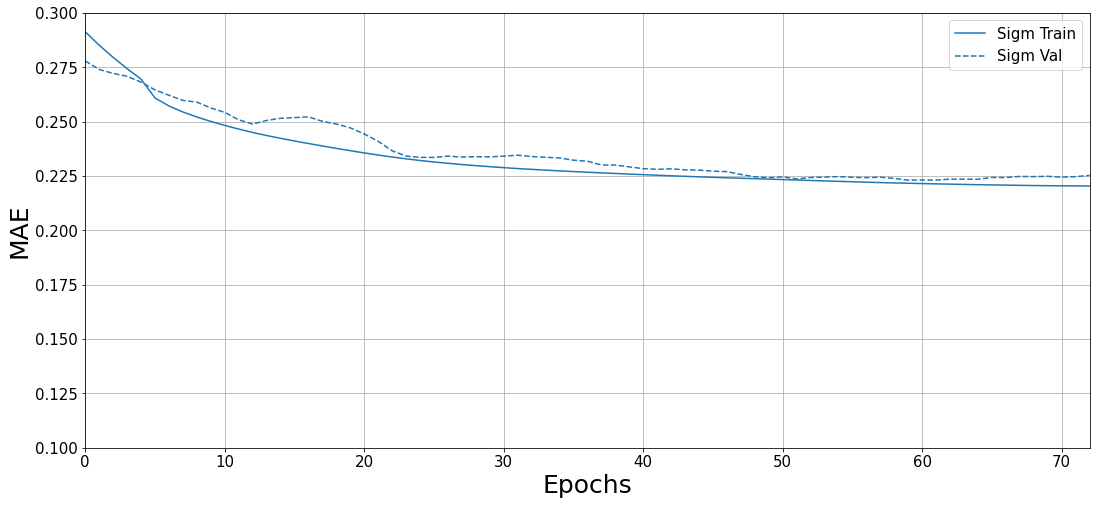

In [43]:
histories['sigm'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.3])
plt.ylabel('MAE')

In [44]:
activ = "ReLU"
model2 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1640,  mae:0.2586,  mse:0.1640,  val_loss:0.1470,  val_mae:0.2372,  val_mse:0.1470,  
................................

Text(0, 0.5, 'MAE')

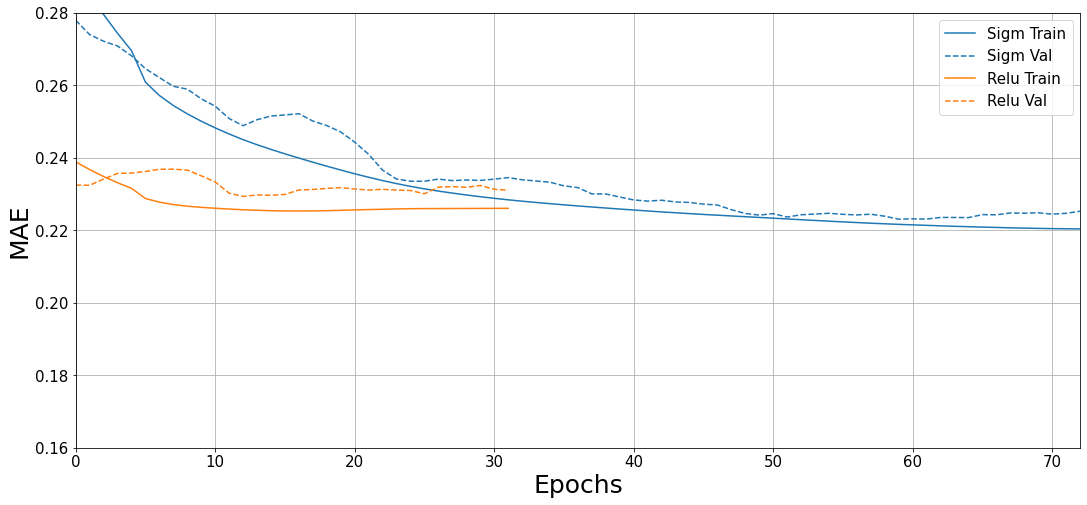

In [45]:
histories['ReLU'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.16, 0.28])
plt.ylabel('MAE')

In [46]:
activ = "ReLU_Adam"
model3 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1627,  mae:0.2594,  mse:0.1627,  val_loss:0.1452,  val_mae:0.2386,  val_mse:0.1452,  
............................................

Text(0, 0.5, 'MAE')

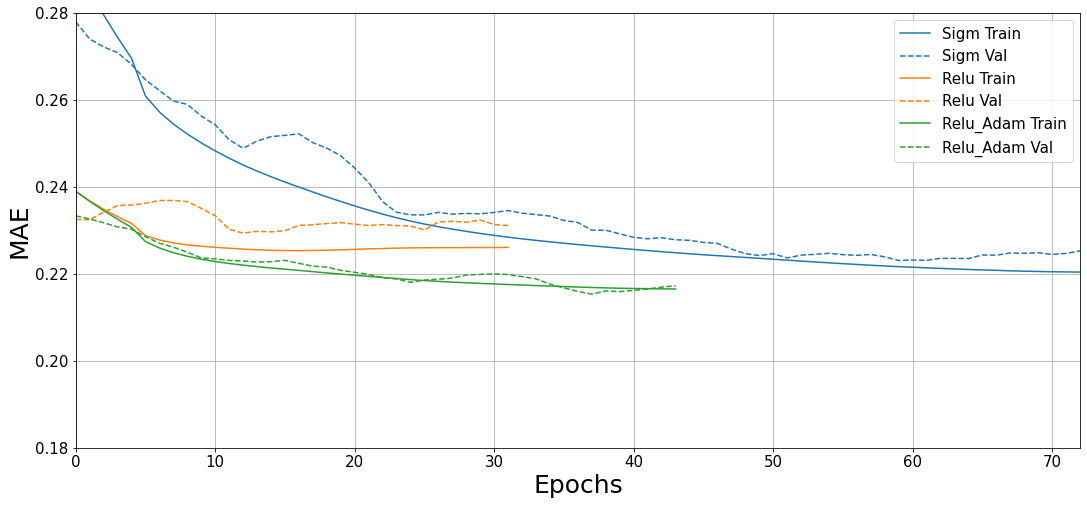

In [48]:
histories['ReLU_Adam'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.18, 0.28])
plt.ylabel('MAE')

In [49]:
activ = "ReLU"
model4 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1471,  mae:0.2424,  mse:0.1471,  val_loss:0.1224,  val_mae:0.2174,  val_mse:0.1224,  
..........................

Text(0, 0.5, 'MAE')

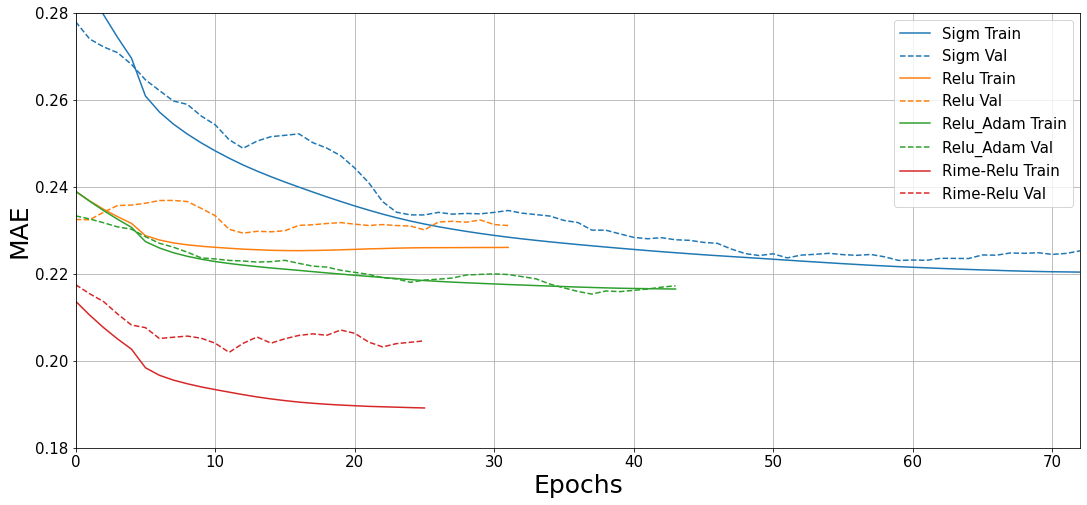

In [50]:
histories['rime-ReLU'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.18, 0.28])
plt.ylabel('MAE')

In [51]:
activ = "ReLU_Adam"
model5 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history5 = model5.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1406,  mae:0.2393,  mse:0.1406,  val_loss:0.1117,  val_mae:0.2082,  val_mse:0.1117,  
...............................

Text(0, 0.5, 'MAE')

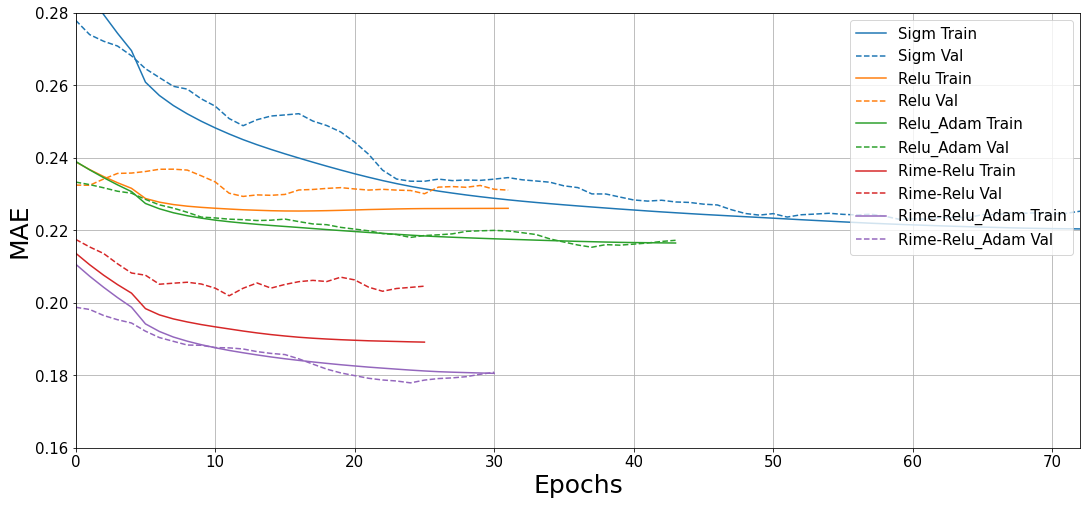

In [52]:
histories['rime-ReLU_Adam'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.16, 0.28])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

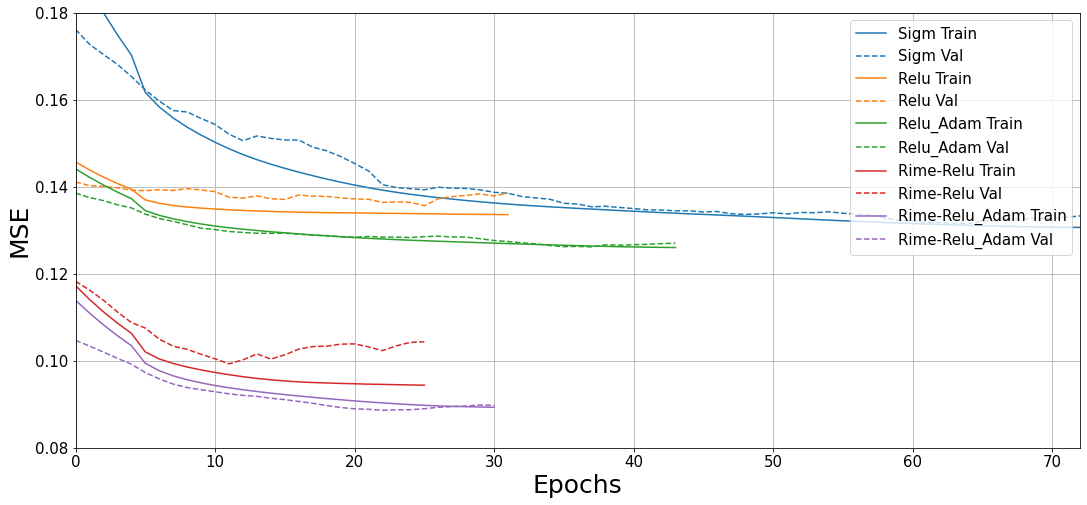

In [53]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.08, 0.18])
plt.ylabel('MSE')

In [54]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

89765/89765 - 2s - loss: 0.1319 - mae: 0.2188 - mse: 0.1319
Testing set for model 1, Mean Abs Error:    0.21880


In [55]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

89765/89765 - 2s - loss: 0.1335 - mae: 0.2223 - mse: 0.1335
Testing set for model 2, Mean Abs Error:              0.22233


In [56]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

89765/89765 - 2s - loss: 0.1269 - mae: 0.2156 - mse: 0.1269
Testing set for model 3, Mean Abs Error:              0.21557


In [57]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

89765/89765 - 2s - loss: 0.0941 - mae: 0.1871 - mse: 0.0941
Testing set for model 4, Mean Abs Error:              0.18705


In [58]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae5))

89765/89765 - 2s - loss: 0.0901 - mae: 0.1786 - mse: 0.0901
Testing set for model 5, Mean Abs Error:              0.17864


In [59]:
mae = [ mae1, mae2, mae3, mae4, mae5 ]
mae

[0.21879557, 0.22233202, 0.2155746, 0.18705346, 0.17864329]

In [60]:
mse = [ mse1, mse2, mse3, mse4, mse5 ]
mse

[0.13192971, 0.13346308, 0.12694268, 0.094110586, 0.09013241]

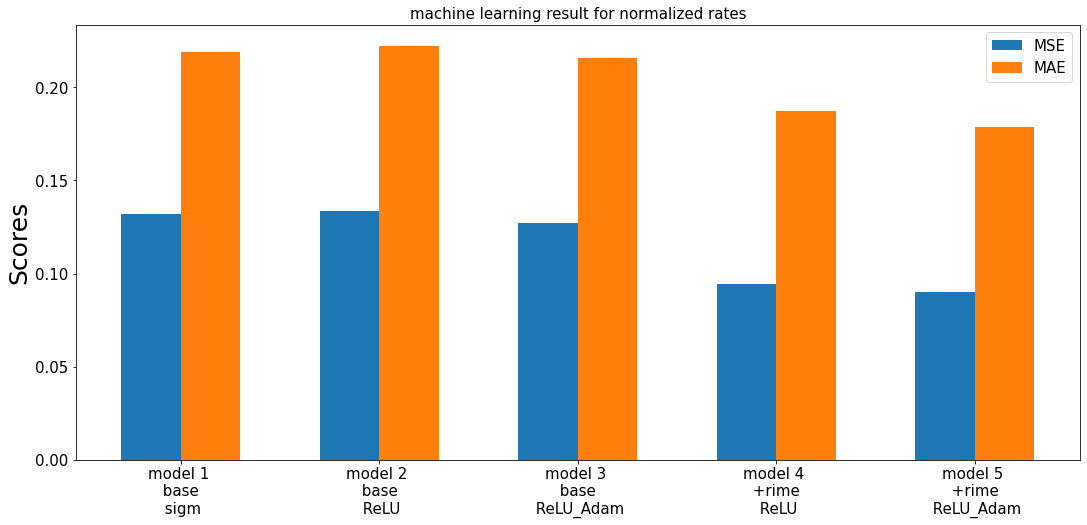

In [61]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1 \n base \n sigm',
 'model 2 \n base \n ReLU',
 'model 3 \n base \n ReLU_Adam',
 'model 4 \n +rime \n ReLU',
 'model 5 \n +rime \n ReLU_Adam' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized rates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [62]:
test_true_mass = np.exp(test_labels.pop('melt_mass'))


In [63]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [64]:
labels = [ "melt_mass" ]

p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=labels)

In [65]:
p1.describe()

melt_mass
count  89765.000000
mean       0.008498
std        0.923660
min       -2.695521
25%       -0.730557
50%        0.091045
75%        0.798181
max        1.820405

In [66]:
test_predict1 = backtransform(p1,train_labels_stats)

In [67]:
test_predict1.describe()

melt_mass
count  89765.000000
mean     -16.020435
std        3.783546
min      -27.096790
25%      -19.047794
50%      -15.682305
75%      -12.785691
max       -8.598400

In [68]:
test_predict1_mass = np.exp(test_predict1['melt_mass'])


In [69]:
p2 = pd.DataFrame(data=model4.predict(normed_test_data2), columns=labels)

test_predict2 = backtransform(p2,train_labels_stats)

test_predict2_mass = np.exp(test_predict2['melt_mass'])

In [70]:
p4 = pd.DataFrame(data=model5.predict(normed_test_data2), columns=labels)

test_predict4 = backtransform(p4,train_labels_stats)

test_predict4_mass = np.exp(test_predict4['melt_mass'])

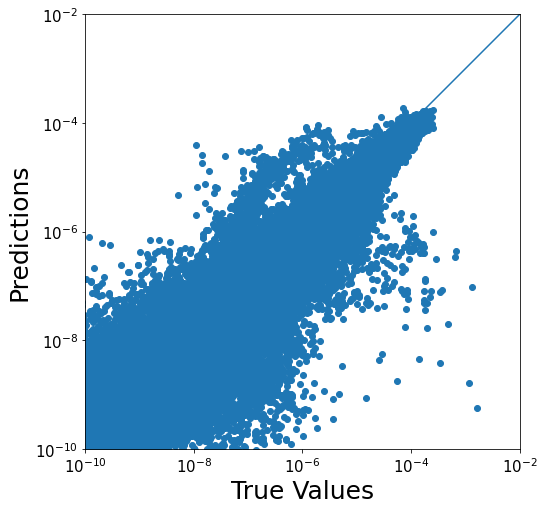

In [71]:
amin, amax = 1e-10, 1e-2

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict1_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

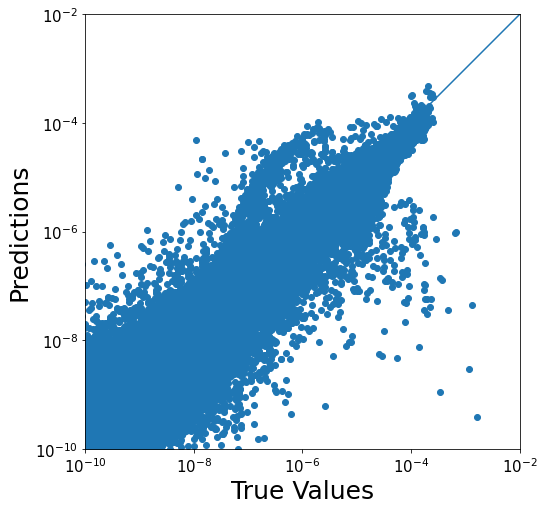

In [72]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict4_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [73]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
version

'17'

In [74]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, labels_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["out_logtransform"] = xr.DataArray(labels_ltf, dims=("Nout_{}".format(nout)))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [75]:
features = 'q_rimedsnow, n_rimedsnow, liq_fraction, (T-T_3)'
labels   = 'melt_mass'
filename = 'saved_model_v2/melt_rimedsnow_liquid_model1_'+version+'.nc'
logtransformInput  = np.array([True, True, False, False], dtype=bool)
logtransformOutput = np.array([True], dtype=bool)
save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransformInput,logtransformOutput,filename)

Saving model to saved_model_v2/melt_rimedsnow_liquid_model1_17.nc
  Features:   q_rimedsnow, n_rimedsnow, liq_fraction, (T-T_3)
  Labels:     melt_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: sigmoid
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear


In [76]:
filename = 'saved_model_v2/melt_rimedsnow_liquid_model2_'+version+'.nc'
save2netcdf(model2,features,labels,train_stats1,train_labels_stats,logtransformInput,logtransformOutput,filename)

Saving model to saved_model_v2/melt_rimedsnow_liquid_model2_17.nc
  Features:   q_rimedsnow, n_rimedsnow, liq_fraction, (T-T_3)
  Labels:     melt_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear


In [77]:
filename = 'saved_model_v2/melt_rimedsnow_liquid_model3_'+version+'.nc'
save2netcdf(model3,features,labels,train_stats1,train_labels_stats,logtransformInput,logtransformOutput,filename)

Saving model to saved_model_v2/melt_rimedsnow_liquid_model3_17.nc
  Features:   q_rimedsnow, n_rimedsnow, liq_fraction, (T-T_3)
  Labels:     melt_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear


In [78]:
features = 'q_rimedsnow, n_rimedsnow, rime_rimedsnow, rvol_rimedsnow, liq_fraction, T-T_3'
filename = 'saved_model_v2/melt_rimedsnow_liquid_model4_'+version+'.nc'
logtransformInput  = np.array([True, True, True, True, False, False], dtype=bool)
save2netcdf(model4,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)

Saving model to saved_model_v2/melt_rimedsnow_liquid_model4_17.nc
  Features:   q_rimedsnow, n_rimedsnow, rime_rimedsnow, rvol_rimedsnow, liq_fraction, T-T_3
  Labels:     melt_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear


In [79]:
filename = 'saved_model_v2/melt_rimedsnow_liquid_model5_'+version+'.nc'
save2netcdf(model5,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)

Saving model to saved_model_v2/melt_rimedsnow_liquid_model5_17.nc
  Features:   q_rimedsnow, n_rimedsnow, rime_rimedsnow, rvol_rimedsnow, liq_fraction, T-T_3
  Labels:     melt_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear


In [80]:
train_stats2

count        mean       std         min         25%         50%  \
q_s     418529.0   -5.820899  1.336782  -19.917505   -6.218014   -5.607128   
num_s   418529.0    3.251293  3.184732  -13.259214    1.990965    3.949242   
rime_s  418529.0   -7.196856  2.089433  -29.111626   -7.907292   -6.809994   
rvol_s  418529.0  -13.196521  2.025964  -34.485615  -13.838964  -12.814621   
liq_s   418529.0    0.460013  0.273612    0.000167    0.216726    0.432005   
temp    418529.0  275.980713  1.923588  273.109985  274.510010  275.579987   

               75%         max  
q_s      -5.102422   -3.506558  
num_s     5.157042   12.768627  
rime_s   -5.896300   -3.627972  
rvol_s  -12.020024   -9.055989  
liq_s     0.683607    1.000000  
temp    276.959991  289.910004